# Tarea 1: Reconocimiento basico
Reconocimiento de Patrones (IIC2233)

Primer semestre 2024

Pedro Pablo Zavala Tejos

# 0. Initial Setup

In [781]:
import numpy as np
import matplotlib.pyplot as plt # Libreria para realizar gráficos
import cv2 # Libreria para procesamiento morfológico de imagenes

# 1. Image Loading


Cargamos los datos


In [782]:
!wget https://www.dropbox.com/scl/fi/5n62okx5uosbdtvwyzova/kchipun.zip?rlkey=obnuogv12isstmblsrdmekjkb&dl=0 # Cargamos los datos

zsh:1: no matches found: https://www.dropbox.com/scl/fi/5n62okx5uosbdtvwyzova/kchipun.zip?rlkey=obnuogv12isstmblsrdmekjkb


In [783]:
!mv kchipun.zip?rlkey=obnuogv12isstmblsrdmekjkb kchipun.zip

zsh:1: no matches found: kchipun.zip?rlkey=obnuogv12isstmblsrdmekjkb


In [784]:
!unzip -qq kchipun.zip # descomprimimos el archivo

unzip:  cannot find or open kchipun.zip, kchipun.zip.zip or kchipun.zip.ZIP.


In [785]:
# Funciones para cargar la imagen
def num2fixstr(x: int, d: int) -> str:
    """
    Funcion que retorna un numero x de d digitos

    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    BASE_URL = 'kchipun/img_'
    DIGITS_CLASS = 2
    DIGITS_IMG = 4
    path = f'{BASE_URL}{num2fixstr(num_class, DIGITS_CLASS)}{sep}{num2fixstr(num_img, DIGITS_IMG)}.png'
    return path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Funcion que retorna la ruta de cada imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
      print(f'loading image {path} ...')
    img = cv2.imread(path, 0)
    return img

def plot_image(num_class: int, num_img: int, echo='off') -> str:
    """
    Funcion que retorna la imagen num_img de clase num_class
    """
    img = imageload(num_class, num_img, echo='on')
    plt.imshow(img, cmap='gray')

loading image kchipun/img_01_0001.png ...


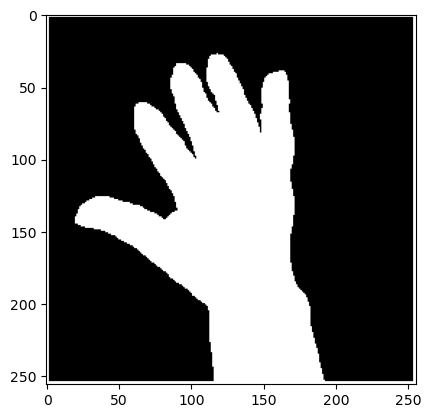

In [786]:
# Veamos el siguiente ejemplo para cargar la primera imagen de cada clase
# 01: Papel; 02: Piedra; 03: Tijera

# Imagen binaria clase papel
plot_image(1, 1)

loading image kchipun/img_02_0001.png ...


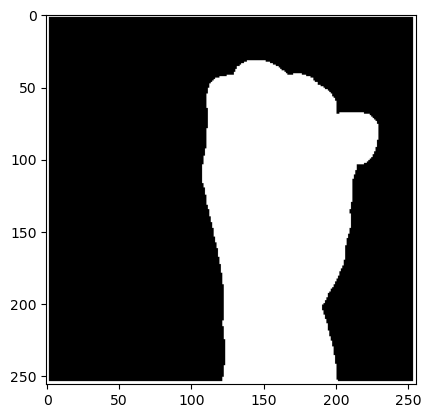

In [787]:
# Imagen binaria clase piedra
plot_image(2, 1)

loading image kchipun/img_03_0001.png ...


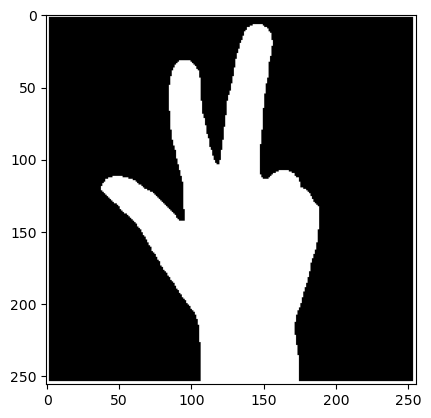

In [788]:
# Imagen binaria clase tijera
plot_image(3, 1)

# 2. Feature Extraction

In [789]:
def erode(img): 
    return cv2.erode(img, np.ones((5,5), np.uint8), iterations=3)

def close(img):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

def dilate(img):
    return cv2.dilate(img, kernel=np.ones((3,3), np.uint8), iterations = 3)

def border(img): 
    kernel = np.ones((2,2), np.uint8)
    erode_img = erode(img)
    border_img = cv2.morphologyEx(erode_img, cv2.MORPH_GRADIENT, kernel)
    border_img = close(border_img)
    return border_img

def delete_frame(img):
    return dilate(erode(img))

def rotate_and_flip(img):
    rotate_img = np.rot90(dilate(erode(img)), k=1)
    flip_img = np.flip(rotate_img, axis=0)
    return flip_img


In [790]:
def get_region(img):
    return img == 255

def center_of_mass(img) -> tuple: 
    region = get_region(img) # region de la imagen 
    region_coords = np.argwhere(region) # coordenadas que pertenecen a la region con valor distinto de 0

    region_coords_i = region_coords[:,0] # coordenadas i
    region_coords_j = region_coords[:,1] # coordenadas j
    
    coords_i_sum = np.sum(region_coords_i) 
    coords_j_sum = np.sum(region_coords_j) 
    area = np.sum(region) 

    return (coords_i_sum / area, coords_j_sum / area) 

def extreme_points(img) -> tuple:
    region_coords = np.argwhere(get_region(img))

    region_axis_j = region_coords[:,0]
    region_axis_i = region_coords[:,1]

    top = tuple(region_coords[region_axis_i.argmin()])
    bottom = tuple(region_coords[region_axis_i.argmax()])
    left = tuple(region_coords[region_axis_j.argmin()])
    right = tuple(region_coords[region_axis_j.argmax()])
    
    return top, bottom, left, right

def distance_between_extreme_points(*points):
    distances = np.array([])

    for i in range(len(points)):
        if i == len(points) - 1:
            distance_between = euclidean_distance(points[i], points[0])
        else:
            distance_between = euclidean_distance(points[i], points[i+1])
        
        distances = np.append(distances, distance_between)
    
    return distances

# def distance_between_cm(*points, center):
#     distances = np.array([])
#     for point in points:
#         distance = euclidean_distance(point, center)
#         distances = np.append(distances, distance)
#     return distances




def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


def normalize_distance(distances):
    return (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

def get_proportion(points_distances):
    prop_left_side = points_distances[0] / points_distances[1] # top to left and left to bottom 
    prop_right_side = points_distances[3] / points_distances[2] # bottom to right and right to top
    proportion = prop_left_side / prop_right_side
    return proportion

def get_feature_data(img):
    img = delete_frame(img)
    top, bottom, left, right = extreme_points(img)
    distances = distance_between_extreme_points(top, bottom, left, right)
    
    proportion = get_proportion(distances)
    return proportion

0.23464878149852952


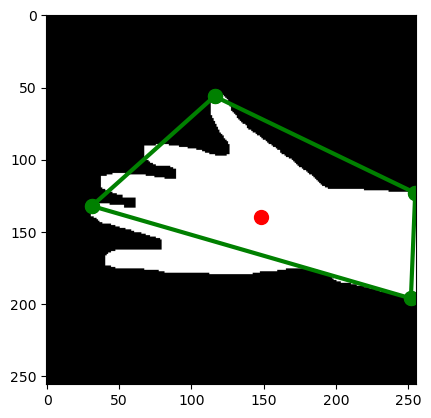

In [800]:

test_image = imageload(1, 3)
processed_image = delete_frame(test_image)
top, bottom, left, right = extreme_points(processed_image)
center = center_of_mass(processed_image)
distances = distance_between_extreme_points(top, left, bottom, right)
# sum_distances = get_sum_extreme_points(distances)
proportion = get_proportion(distances)
print(proportion)


plt.plot(*center, 'ro', markersize=10)
plt.plot([top[0], right[0]], [top[1], right[1]], 'go', linestyle='-', linewidth=3, markersize=10)
plt.plot([top[0], left[0]], [top[1], left[1]], 'go', linestyle='-', linewidth=3, markersize=10)
plt.plot([bottom[0], left[0]], [bottom[1], left[1]], 'go', linestyle='-', linewidth=3, markersize=10)
plt.plot([bottom[0], right[0]], [bottom[1], right[1]], 'go', linestyle='-', linewidth=3, markersize=10)

plt.imshow(rotate_and_flip(test_image), cmap='gray')
plt.show()


792.028172774367


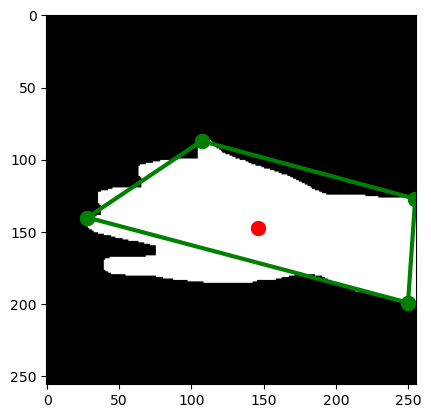

In [792]:
test_image = imageload(1, 15)
processed_image = delete_frame(test_image)
top, bottom, left, right = extreme_points(processed_image)
center = center_of_mass(processed_image)
distances = distance_between_extreme_points(top, bottom, left, right)
sum_distances = get_sum_extreme_points(distances)
print(sum_distances)


plt.plot(*center, 'ro', markersize=10)
plt.plot([top[0], right[0]], [top[1], right[1]], 'go', linestyle='-', linewidth=3, markersize=10)
plt.plot([top[0], left[0]], [top[1], left[1]], 'go', linestyle='-', linewidth=3, markersize=10)
plt.plot([bottom[0], left[0]], [bottom[1], left[1]], 'go', linestyle='-', linewidth=3, markersize=10)
plt.plot([bottom[0], right[0]], [bottom[1], right[1]], 'go', linestyle='-', linewidth=3, markersize=10)

plt.imshow(rotate_and_flip(test_image), cmap='gray')
plt.show()

In [793]:
K = 3 # Cantidad de clases
N = 50 # Numero de muestras por clases

X = np.zeros((N * K, )) # Creamos un arreglo de tamaño N * K con las caracteristicas
Y = np.zeros((N * K, )) # Creamos nuestra variable de respuesta (con las clases)
index = 0

for k in range(1, K + 1):
    for i in range(1, N + 1):
        img = imageload(k, i, echo='on')
        X[index] = get_feature_data(img)
        Y[index] = K

        index += 1

loading image kchipun/img_01_0001.png ...
loading image kchipun/img_01_0002.png ...
loading image kchipun/img_01_0003.png ...
loading image kchipun/img_01_0004.png ...
loading image kchipun/img_01_0005.png ...
loading image kchipun/img_01_0006.png ...
loading image kchipun/img_01_0007.png ...
loading image kchipun/img_01_0008.png ...
loading image kchipun/img_01_0009.png ...
loading image kchipun/img_01_0010.png ...
loading image kchipun/img_01_0011.png ...
loading image kchipun/img_01_0012.png ...
loading image kchipun/img_01_0013.png ...
loading image kchipun/img_01_0014.png ...
loading image kchipun/img_01_0015.png ...
loading image kchipun/img_01_0016.png ...
loading image kchipun/img_01_0017.png ...
loading image kchipun/img_01_0018.png ...
loading image kchipun/img_01_0019.png ...
loading image kchipun/img_01_0020.png ...
loading image kchipun/img_01_0021.png ...
loading image kchipun/img_01_0022.png ...
loading image kchipun/img_01_0023.png ...
loading image kchipun/img_01_0024.

# 3. Training and testing subsets

In [794]:
# Datos de entrenamiento de las primeras 40 imagenes de cada clase
x0_train = X[0:40]
x1_train = X[50:90]
x2_train = X[100:140]

# Datos de testeo de las ultimas 10 imagenes de cada clase
x0_test = X[40:50]
x1_test = X[90:100]
x2_test = X[140:150]

# Estadisticas de cada clase
# Maximo de cada clase
x0_max = np.max(x0_train)
x1_max = np.max(x1_train)
x2_max = np.max(x2_train)
# Minimo de cada clase
x0_min = np.min(x0_train)
x1_min = np.min(x1_train)
x2_min = np.min(x2_train)
# Promedio de cada clase
x0_mean = np.mean(x0_train)
x1_mean = np.mean(x1_train)
x2_mean = np.mean(x2_train)


print('Statistics')

print('Class 1 (paper):')
print('>>>> min  = '+str(x0_min))
print('>>>> mean = '+str(x0_mean))
print('>>>> max  = '+str(x0_max))
print(' ')

print('Class 2 (rock):')
print('>>>> min  = '+str(x1_min))
print('>>>> mean = '+str(x1_mean))
print('>>>> max  = '+str(x1_max))

print('Class 3 (scissors):')
print('>>>> min  = '+str(x2_min))
print('>>>> mean = '+str(x2_mean))
print('>>>> max  = '+str(x2_max))


Statistics
Class 1 (paper):
>>>> min  = 1.0719332562617918
>>>> mean = 1.347772448832502
>>>> max  = 3.098577719000793
 
Class 2 (rock):
>>>> min  = 1.0638367196673237
>>>> mean = 1.5946131364465537
>>>> max  = 2.2622469655464794
Class 3 (scissors):
>>>> min  = 1.1921866962280723
>>>> mean = 1.6214013017966629
>>>> max  = 2.5884461861705352


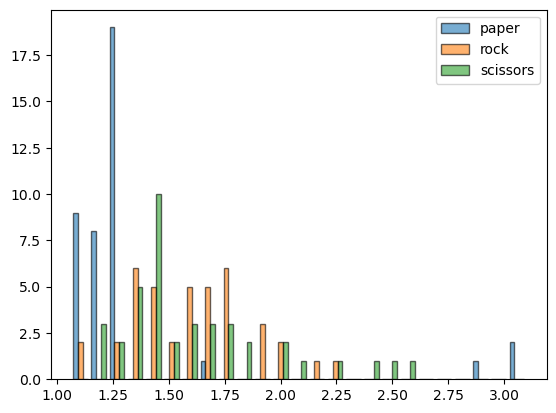

In [795]:
# Histograma de análisis de caracteristicas 
plt.hist([x0_train, x1_train, x2_train], bins=25, label=['paper', 'rock', 'scissors'], alpha=0.6, histtype='bar', ec='black')
plt.legend()
plt.show()

# 4. Classification

In [796]:
threshold_1 = (x0_mean + x1_mean) / 2
threshold_2 = (x1_mean + x2_mean) / 2

def classifier(x):
    if x < threshold_1:
        return 1 # classified as paper
    elif  x < threshold_2:
        return 2 # classified as rock
    else:
        return 3 # classidied as scissors
    
Y = np.array([classifier(x) for x in X])

Y1_test = Y[40:50]
Y2_test = Y[90:100]
Y3_test = Y[140:150]

Y1_train = Y[0:40]
Y2_train = Y[50:90]
Y3_train = Y[100:140]

# 5. Evaluation

In [797]:

def print_accuracy(accuracy, type):
    print(f'\n{type} Accuracy = {accuracy}%')

def get_accuracy(Y, type):
    true_samples = 0
    false_samples = 0
    
    for k in range(3):
        true_samples += np.sum(Y[k] == k + 1)
        false_samples += np.sum(Y[k] != k + 1)
    
    accuracy = true_samples / (true_samples + false_samples) * 100
    
    print_accuracy(accuracy, type)

    return accuracy
        

def total_accuracy(acc_test, acc_train):
    return 0.20 * acc_train + 0.8 * acc_test

In [802]:
Y_test = np.array([Y1_test, Y2_test, Y3_test])
Y_train = np.array([Y1_train, Y2_train, Y3_train])

AccTest = get_accuracy(Y_test, 'Testing')
AccTrain = get_accuracy(Y_train, 'Training')
AccTot = total_accuracy(AccTest, AccTrain)
print_accuracy(AccTot, 'Total')


# paper_true = np.sum(Y1_test == 1)   
# rock_true = np.sum(Y2_test == 2)
# scissors_true = np.sum(Y3_test == 3)
# paper_false = np.sum(Y1_test != 1)
# rock_false = np.sum(Y2_test != 2)
# scissors_false = np.sum(Y3_test != 3)

# # accuracy = (paper_true + rock_true + scissors_true) / (paper_true + rock_true + scissors_true + paper_false + rock_false + scissors_false)
# # print(f'Testing Accuracy = {accuracy * 100}%')




Testing Accuracy = 36.666666666666664%

Training Accuracy = 48.333333333333336%

Total Accuracy = 39.0%
